# What we've learned 

*from classification_task_benchmark*

-Cleaning doesn't have a noticeable effect on performance\
-Imbalance of the classes is a problem. Downsampling was our first approach\
-Taking the mean of the token's representation seems to work.
-distiled-Bert works better

# What we are going to test here

-Training with less downsampling\
-Training with different loss function to look for minority class\
-How much influence does the padding have over the quality of the representation (varying max token truncation).


In [1]:
# imports
import sys  
sys.path.insert(0, '../../../TwitterCoordinatedInorganicAgents')

import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModel
from transformers import AutoTokenizer
import numpy as np
from tweetcore.tasks.postgres_target import download_data
from data_builders.tasks import collapse_embeddings
import credentials_refactor
import global_settings as gs
import gc

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc, confusion_matrix

# Data ready

In [11]:
# data
conf = credentials_refactor.return_credentials()
data = download_data.pandas_df_from_postgre_query(configuration = conf ,
                                                  query = '''
                                                          select*
                                                          from ( 
                                                          select *
                                                          from tweetcore.migration_development
                                                          where label = 'human'
                                                          order by index
                                                          limit 50000 ) t0
                                                          union all
                                                          select *
                                                          from ( 
                                                          select *
                                                          from tweetcore.migration_development
                                                          where label = 'bot'
                                                          order by index
                                                          limit 50000 ) t0
                                                          ''')
test = download_data.pandas_df_from_postgre_query(configuration = conf ,
                                                  query = '''
                                                          select *
                                                          from tweetcore.migration_development
                                                          order by index desc
                                                          limit 50000
                                                  ''')


<AxesSubplot:xlabel='label', ylabel='count'>

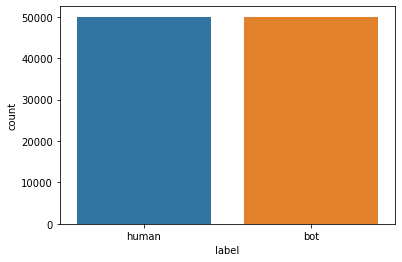

In [3]:
sns.countplot(x=data.label)

# Benchmark with less downsampling 

## Code

In [14]:
data.loc[:,"target"] = data.label.map(lambda x: 1 if x=='bot' else 0)
test.loc[:,"target"] = test.label.map(lambda x: 1 if x=='bot' else 0)

In [15]:
# imbalance
print(sum(data.target)/data.shape[0])
print(sum(test.target)/test.shape[0])

0.5
0.23684


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
                                        data[["index", "target", "text"]], 
                                        data.target, 
                                        test_size=0.3, 
                                        random_state=42
                                        )

In [7]:
max(data["index"])/5000

52.08

In [8]:
max(test["index"])

599999

In [9]:
# training data
path_140 = f'{gs.data_path}/nlp/embeddings/140'
data_emb, path_permanent = collapse_embeddings.read_embeddings_simple(path=path_140,
                                                                      number_of_files=53,
                                                                      emb_dim=768,
                                                                      collapse_tweet=True,
                                                                      save_on_disk=True)

53/53
--- Ended ---


In [10]:
# validation imabalanced
files_generated = []
for i in range(10):
    root = 'development_140_'+str(5500+(i+1)*50)+'.npy'
    files_generated.append(root)
test_emb, path_test_permanent = collapse_embeddings.read_embeddings_simple(path=path_140,
                                                                           files = files_generated,
                                                                           emb_dim=768,
                                                                           collapse_tweet=True, 
                                                                           save_on_disk=True)

10/10
--- Ended ---


In [11]:
X_train_emb = data_emb[list(X_train["index"].values)]

In [12]:
X_test_emb = data_emb[list(X_test["index"].values)]

In [ ]:
# test different models

rf = RandomForestClassifier()
lr = LogisticRegression(max_iter=1000)
kn = KNeighborsClassifier()

all_models = {"LogisticRegression":lr,"RandomForest":rf,  "K-Neighbors":kn}

for name, model in zip(all_models.keys(), all_models.values()):
    cv_results = cross_validate(model, 
                            X_train_emb, 
                            y_train, 
                            cv=5,
                            scoring=["f1"])
    print(name + " with mean accuracy over 5 folds of: " + str(round(np.mean(cv_results["test_f1"]),4)) + " and sigma accross test metrics of: " + str(round(np.std(cv_results["test_f1"]),4)))

In [13]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_emb,y_train)

LogisticRegression(max_iter=1000)

## [benchmark] Imbalance training: 0.5 & Imbalance validation: 0.5

In [14]:
print(classification_report(y_test, model.predict(X_test_emb)))

              precision    recall  f1-score   support

           0       0.57      0.59      0.58     15055
           1       0.57      0.55      0.56     14945

    accuracy                           0.57     30000
   macro avg       0.57      0.57      0.57     30000
weighted avg       0.57      0.57      0.57     30000



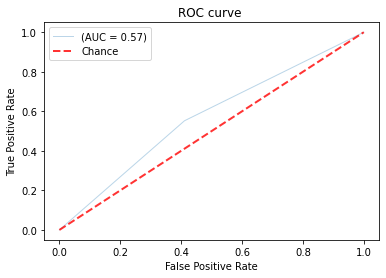

In [15]:
# ROC curve
y_true = y_test
y_pre = model.predict(X_test_emb)
ax1=plt.subplot(111)
fpr, tpr, thresholds = roc_curve(y_true, y_pre)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, lw=1, alpha=0.3,label='(AUC = %0.2f)'%roc_auc)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC curve ')
ax1.legend(loc='best')
    

## Code

In [16]:
# train with all data
data_random = data.sample(frac=1).copy()
model = LogisticRegression(max_iter=10000)
model.fit(data_emb[list(data_random["index"].values)],data_random.target)

LogisticRegression(max_iter=10000)

In [17]:
# imbalance test data
print(sum(test.target)/test.shape[0])

0.23684


In [17]:
test_random = test.sample(frac=1).copy()

In [19]:
y_pred = model.predict(test_emb[list(test_random["index"].values-550000)])
y_test1 = test_random.target

## [benchmark] Imabalance training: 0.5 & Imabalance validation: 0.24

In [20]:
# benchmark
print(classification_report(y_test1, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.63      0.69     38158
           1       0.25      0.39      0.30     11842

    accuracy                           0.57     50000
   macro avg       0.51      0.51      0.50     50000
weighted avg       0.65      0.57      0.60     50000



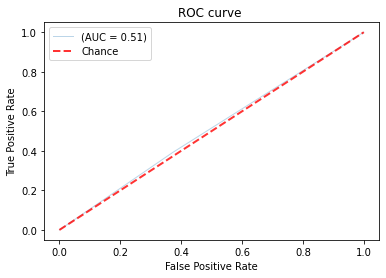

In [21]:
# ROC curve
y_true = y_test1.copy()
y_pre = y_pred.copy()
ax1=plt.subplot(111)
fpr, tpr, thresholds = roc_curve(y_true, y_pre)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, lw=1, alpha=0.3,label='(AUC = %0.2f)'%roc_auc)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC curve ')
ax1.legend(loc='best')
    

# Benchmark varying downsampling ratios

In [9]:
conf = credentials_refactor.return_credentials()

In [5]:
path_140 = f'{gs.data_path}/nlp/embeddings/140'
data_emb = np.load(path_140+'/development_140_final_permanent.npy')
test_emb = np.load(path_140+'/development_140_final_new_permanent.npy')

In [18]:
results = {}
for i in range(1,11):
    human_increment = 10000*i
    query_temp = f'''
                    select*
                    from ( 
                        select *
                        from tweetcore.migration_development
                        where label = 'human'
                        order by index
                        limit 50000 + {human_increment}
                    ) t0
                    union all
                    select *
                    from ( 
                        select *
                        from tweetcore.migration_development
                        where label = 'bot'
                        order by index
                        limit 50000 
                    ) t0
                    '''
    data_imb = download_data.pandas_df_from_postgre_query(configuration = conf ,
                                                  query =query_temp)
    print(data_imb.shape[0])
    print('--- Data done ---')
    data_imb.loc[:,"target"] = data_imb.label.map(lambda x: 1 if x=='bot' else 0)
    data_random_imb = data_imb.sample(frac=1).copy()
    
    # training 
    model_imb = LogisticRegression(max_iter=10000)
    model_imb.fit(data_emb[list(data_random_imb["index"].values)],data_random_imb.target)
    print('--- Done training ---')
    
    # performance
    imbalance = round(sum(data_random_imb.target)/len(data_random_imb.target),4)
    y_test1 = test_random.target
    y_pred = model_imb.predict(test_emb[list(test_random["index"].values-550000)])
    results[imbalance] = classification_report(y_test1, y_pred, output_dict=True)
    
    print(f'--- Done imbalance: {imbalance} ---\n')
    del data_imb, data_random_imb
    gc.collect()

110000
--- Data done ---
--- Done training ---
--- Done imbalance: 0.4545 ---

120000
--- Data done ---
--- Done training ---
--- Done imbalance: 0.4167 ---

130000
--- Data done ---
--- Done training ---
--- Done imbalance: 0.3846 ---

140000
--- Data done ---
--- Done training ---
--- Done imbalance: 0.3571 ---

150000
--- Data done ---
--- Done training ---
--- Done imbalance: 0.3333 ---

160000
--- Data done ---
--- Done training ---
--- Done imbalance: 0.3125 ---

170000
--- Data done ---
--- Done training ---
--- Done imbalance: 0.2941 ---

180000
--- Data done ---
--- Done training ---
--- Done imbalance: 0.2778 ---

190000
--- Data done ---
--- Done training ---
--- Done imbalance: 0.2632 ---

200000
--- Data done ---
--- Done training ---
--- Done imbalance: 0.25 ---



In [27]:
results

{0.4545: {'0': {'precision': 0.7692327630896838,
   'recall': 0.7777399234760731,
   'f1-score': 0.7734629518621804,
   'support': 38158},
  '1': {'precision': 0.25735551663747813,
   'recall': 0.24818442830602938,
   'f1-score': 0.2526867853151062,
   'support': 11842},
  'accuracy': 0.65232,
  'macro avg': {'precision': 0.513294139863581,
   'recall': 0.5129621758910512,
   'f1-score': 0.5130748685886433,
   'support': 50000},
  'weighted avg': {'precision': 0.6479997560399434,
   'recall': 0.65232,
   'f1-score': 0.6501223245771713,
   'support': 50000}},
 0.4167: {'0': {'precision': 0.7678563173223614,
   'recall': 0.8705644949944966,
   'f1-score': 0.815991156963891,
   'support': 38158},
  '1': {'precision': 0.2669931730483823,
   'recall': 0.15191690592805268,
   'f1-score': 0.1936490850376749,
   'support': 11842},
  'accuracy': 0.70036,
  'macro avg': {'precision': 0.5174247451853718,
   'recall': 0.5112407004612747,
   'f1-score': 0.504820121000783,
   'support': 50000},
  'w

## Effect on data

In [2]:
path_140 = f'{gs.data_path}/nlp/embeddings/140'
a = np.load(path_140+'/development_140_final_permanent.npy')

In [4]:
a[:100]

array([[ 0.0834819 , -0.00376278,  0.2954853 , ...,  0.00209416,
        -0.00044725, -0.03948679],
       [ 0.1633248 , -0.0378776 ,  0.14849399, ..., -0.0316375 ,
        -0.04201998,  0.34096443],
       [-0.04395941, -0.28131193,  0.26860944, ..., -0.03856604,
         0.02407258, -0.15145411],
       ...,
       [ 0.13575707, -0.01304994,  0.18076054, ..., -0.03827782,
        -0.19625903, -0.04933203],
       [-0.00779551, -0.02711803,  0.10427203, ..., -0.02906885,
        -0.12142759,  0.04888946],
       [ 0.05977851, -0.06536224,  0.22635887, ...,  0.06177156,
        -0.06707874,  0.04495548]])

# Might be needed later

In [ ]:
dummy_tweet = '''

    This is a dummy text to max out the number of tokens. This is a dummy text to max out the number of tokens. This 
    is a dummy text to max out the number of tokens. This is a dummy text to max out the number of tokens. This is a 
    dummy text to max out the number of tokens .This is a dummy text to max out the number of tokens. This is a dummy 
    text to max out the number of tokens. This is a dummy text to max out the number of tokens. This is a dummy text 
    to max out the number of tokens. This is a dummy text to max out the number of tokens. This is a dummy text to 
    max out the number of tokens. This is a dummy text to max out the number of tokens. This is a dummy text to max 
    out the number of tokens. This is a dummy text to max out the number of tokens. This is a dummy text to max out 
    the number of tokens .This is a dummy text to max out the number of tokens. This is a dummy text to max out the 
    number of tokens. This is a dummy text to max out the number of tokens. This is a dummy text to max out the 
    number of tokens. This is a dummy text to max out the number of tokens 

'''

In [ ]:
model_name='distilbert-base-uncased'
splits=1
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to('cuda')
tokens = tokenizer([dummy_tweet]+list(data.head(100).text.values) ,
                   truncation=True, 
                   max_length=140,
                   return_tensors='pt', 
                   padding=True).to('cuda')
    
ids = np.array_split(tokens.input_ids[1:,:], splits)
attentions = np.array_split(tokens.attention_mask[1:,:], splits)
embd_batch = model(input_ids=ids[0],
                           attention_mask=attentions[0],
                           output_attentions=False, 
                           output_hidden_states=False)

In [ ]:
emb = embd_batch.last_hidden_state.to('cpu').detach().numpy()

In [ ]:
ans = np.mean(emb, axis=1)

In [ ]:
ans[0]

In [ ]:
X_train_emb[381]

In [ ]:
y_train.values[52521]

In [ ]:
b = np.load(gs.data_path+'/nlp/embeddings/140' + '/development_140_50.npy',mmap_mode='r')

In [ ]:
np.mean(b[1],axis=0)

In [ ]:
emb[0][0]

In [ ]:
a[0].shape

In [ ]:
emb.shape

In [ ]:
b = np.load(gs.data_path+'/nlp/embeddings/140' + '/development_140_3950.npy',mmap_mode='r')

In [ ]:
save_path = gs.data_path+'/nlp/embeddings/140' + '/development_140'

In [ ]:
save_path

In [ ]:
representation = np.zeros((1, gs.max_char_tweet, 768))
np.save(f'{save_path}_final', representation[1:, :, :])

In [ ]:
representation[1:, :, :]

In [ ]:
path_140 = f'{gs.data_path}/nlp/embeddings/140'
a = np.load(f'{gs.data_path}/nlp/embeddings/140/development_140_50.npy', mmap_mode='r' )
#b = np.load('../../data/nlp/embeddings/development_140_100.npy', mmap_mode='r' )

In [ ]:
a

In [ ]:
a.shape

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

inputs = tokenizer([dummy_tweet]+["Hello, my dog is cute"] + list(data.head(100).text.values),                  
                   truncation=True, 
                   max_length=140,
                   return_tensors='pt', 
                   padding=True)
outputs = model(input_ids=inputs.input_ids[1:],
                attention_mask=inputs.attention_mask[1:],)

last_hidden_states = outputs[0].to('cpu').detach().numpy()

In [ ]:
(last_hidden_states[0][0] == last_hidden_states_s[0][0]).all()

In [ ]:
last_hidden_states[0][0]

In [ ]:
last_hidden_states_s[0][0]